In [ ]:
# 1. Persiapan Environment dan Import Libraries
# Install dependencies
!pip install transformers datasets torch pandas openpyxl scikit-learn accelerate

import pandas as pd
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 2. Load dan Preprocessing Data
# Load data
train_df = pd.read_excel('dataset_train.xlsx')
test_df = pd.read_excel('dataset_test.xlsx')

# Cek distribusi data
print("Train distribution:")
print(train_df['sentiment_manual'].value_counts())
print("\nTest distribution:")
print(test_df['sentiment_manual'].value_counts())

# Mapping label ke angka
label_mapping = {
    'positif': 0,
    'negatif': 1,
    'netral': 2
}

# Reverse mapping untuk interpretasi hasil
id2label = {0: 'positif', 1: 'negatif', 2: 'netral'}
label2id = {'positif': 0, 'negatif': 1, 'netral': 2}

# Gabungkan text dengan notes jika ada (opsional tapi bisa membantu)
def prepare_text(row):
    text = str(row['comment_translated'])
    # Jika sentiment_notes ada dan tidak kosong, tambahkan sebagai konteks
    if pd.notna(row['sentiment_notes']) and str(row['sentiment_notes']).strip():
        text = f"{text} [Context: {row['sentiment_notes']}]"
    return text

train_df['text'] = train_df.apply(prepare_text, axis=1)
test_df['text'] = test_df.apply(prepare_text, axis=1)

train_df['label'] = train_df['sentiment_manual'].map(label_mapping)
test_df['label'] = test_df['sentiment_manual'].map(label_mapping)

# Convert ke Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

Train distribution:
sentiment_manual
positif    800
negatif    800
netral     800
Name: count, dtype: int64

Test distribution:
sentiment_manual
positif    200
netral     200
negatif    200
Name: count, dtype: int64


In [ ]:
# 3. Load IndoBERT dan Tokenizer
# Load IndoBERT model dan tokenizer
model_name = "indobenchmark/indobert-base-p1"  # Bisa juga "indobenchmark/indobert-base-p1" atau "indolem/indobert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# Tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=512  # Sesuaikan dengan kebutuhan
    )

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
# 4. Metrics untuk Evaluasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)

    # Confusion matrix
    cm = confusion_matrix(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# 5. Hyperparameter Tuning dan Training
# Training arguments dengan hyperparameter yang sudah dioptimasi
training_args = TrainingArguments(
    output_dir='./results',

    # Training parameters
    num_train_epochs=5,  # Bisa 3-5 epoch
    per_device_train_batch_size=16,  # Sesuaikan dengan GPU memory
    per_device_eval_batch_size=32,

    # Learning rate
    learning_rate=2e-5,  # Typical range: 2e-5 to 5e-5
    warmup_steps=500,  # Atau warmup_ratio=0.1
    weight_decay=0.01,

    # Evaluation & Saving
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    # Logging
    logging_dir='./logs',
    logging_steps=50,

    # Optimization
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision training
    gradient_accumulation_steps=2,  # Jika GPU memory terbatas

    # Early stopping
    save_total_limit=2,

    # Seed untuk reproducibility
    seed=42
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Start training
print("Starting training...")
trainer.train()

# Save best model
trainer.save_model('./best_model')
tokenizer.save_pretrained('./best_model')

/tmp/ipython-input-511679995.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kazenesia (kazenesia-muhammadiyah-sidoarjo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.080000,0.648165,0.880000,0.880287,0.882936,0.880000
2,0.104800,0.062956,0.980000,0.980054,0.980462,0.980000
3,0.041700,0.057665,0.986667,0.986661,0.986831,0.986667
4,0.029400,0.070039,0.983333,0.983331,0.983636,0.983333
5,0.026500,0.059211,0.990000,0.990000,0.990024,0.990000


('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')


=== Evaluasi pada Test Set ===


{'eval_loss': 0.059211477637290955, 'eval_accuracy': 0.99, 'eval_f1': 0.9899998753101659, 'eval_precision': 0.9900243793223543, 'eval_recall': 0.99, 'eval_runtime': 4.35, 'eval_samples_per_second': 137.93, 'eval_steps_per_second': 4.368, 'epoch': 5.0}

=== Classification Report ===
              precision    recall  f1-score   support

     positif       0.99      0.99      0.99       200
     negatif       0.99      0.99      0.99       200
      netral       0.99      0.98      0.99       200

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



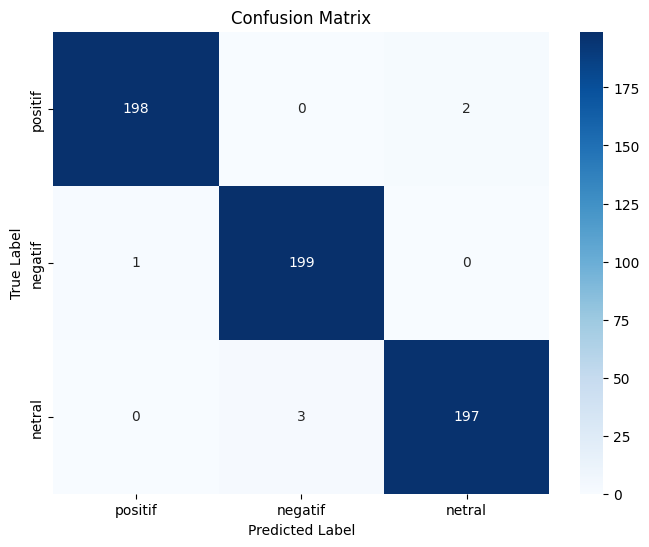

In [ ]:
# 6. Evaluasi Detail
# Evaluate pada test set
print("\n=== Evaluasi pada Test Set ===")
results = trainer.evaluate()
print(results)

# Prediksi untuk analisis lebih detail
predictions = trainer.predict(tokenized_test)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Classification report
from sklearn.metrics import classification_report
print("\n=== Classification Report ===")
print(classification_report(
    labels,
    preds,
    target_names=['positif', 'negatif', 'netral']
))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positif', 'negatif', 'netral'],
            yticklabels=['positif', 'negatif', 'netral'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
# 7. Testing Inference
# Load model terbaik untuk inference
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model='./best_model',
    tokenizer='./best_model',
    device=0 if torch.cuda.is_available() else -1
)

# Test beberapa contoh
test_texts = [
    "semoga ini menjadi tiket untuk kemajuan lebih lanjut dalam pembangunan nasional kita amin",
    "pihak sekolah main aman bukan goblok",
    "ya kalau harus bawa lauk dari rumah biar kenyang gagal dong programnya"
]

for text in test_texts:
    result = classifier(text)[0]
    print(f"Text: {text}")
    print(f"Prediction: {result['label']} (confidence: {result['score']:.4f})\n")

Device set to use cuda:0


Text: semoga ini menjadi tiket untuk kemajuan lebih lanjut dalam pembangunan nasional kita amin
Prediction: positif (confidence: 0.9949)

Text: pihak sekolah main aman bukan goblok
Prediction: negatif (confidence: 0.9150)

Text: ya kalau harus bawa lauk dari rumah biar kenyang gagal dong programnya
Prediction: positif (confidence: 0.9689)



In [14]:
# 8. Kompres dan Download Folder Proses
import os
from google.colab import files

# 1. Definisikan folder-folder yang ingin Anda unduh
folders_to_zip = ["best_model", "logs", "results", "sample_data", "wandb"]
output_zip_filename = "downloaded_folders.zip"

# 2. Buat perintah shell untuk mengkompresi folder-folder tersebut
# Perintah "zip -r" akan mengkompresi secara rekursif (termasuk isi sub-folder)
zip_command = f"zip -r {output_zip_filename} " + " ".join(folders_to_zip)

print(f"Menjalankan perintah: {zip_command}")

# 3. Jalankan perintah kompresi di Google Colab
# Penggunaan '!' di awal menjalankan perintah shell
!{zip_command}

# 4. Unduh file ZIP yang telah dibuat
print("\nProses kompresi selesai. Sekarang mengunduh file...")
try:
    files.download(output_zip_filename)
    print(f"\nBerhasil mengunduh '{output_zip_filename}'.")
except Exception as e:
    print(f"\nTerjadi kesalahan saat mengunduh: {e}")
    print("Pastikan file ZIP telah berhasil dibuat dan coba lagi.")

Menjalankan perintah: zip -r downloaded_folders.zip best_model logs results sample_data wandb
  adding: best_model/ (stored 0%)
  adding: best_model/vocab.txt (deflated 53%)
  adding: best_model/model.safetensors (deflated 7%)
  adding: best_model/training_args.bin (deflated 53%)
  adding: best_model/config.json (deflated 55%)
  adding: best_model/tokenizer.json (deflated 71%)
  adding: best_model/tokenizer_config.json (deflated 74%)
  adding: best_model/special_tokens_map.json (deflated 42%)
  adding: logs/ (stored 0%)
  adding: logs/events.out.tfevents.1760584003.22ca72f946cf.373.1 (deflated 30%)
  adding: logs/events.out.tfevents.1760583506.22ca72f946cf.373.0 (deflated 61%)
  adding: results/ (stored 0%)
  adding: results/checkpoint-375/ (stored 0%)
  adding: results/checkpoint-375/vocab.txt (deflated 53%)
  adding: results/checkpoint-375/trainer_state.json (deflated 72%)
  adding: results/checkpoint-375/rng_state.pth (deflated 26%)
  adding: results/checkpoint-375/model.safetensors

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Berhasil mengunduh 'downloaded_folders.zip'.
